In [1]:
%autosave 0

Autosave disabled


In [2]:
import warnings
warnings.filterwarnings('ignore')
# For ignoring warnings printed by R magic commands

In [3]:
import os
import glob

In [4]:
# Import pandas
import pandas as pd

In [5]:
# Load R magic
%load_ext rpy2.ipython
# Import ggplot2
%R require(ggplot2);

In [6]:
# If experiment parameters change, modify this function
def AddParametersAsColumns(df, folder):
    expParams = folder.split('.')
    cloudParams = expParams[1].split('_')
    optimizerParams = expParams[2].split('_')
    dynamicParams = expParams[3].split('_')
    df['groupSizeDist'] = cloudParams[9]
    df['placementDist'] = cloudParams[10]
    df['colocateNumHostsPerLeaf'] = int(cloudParams[11])
    df['seed'] = int(cloudParams[14])
    df['algorithm'] = optimizerParams[1]
    df['numBitmaps'] = int(optimizerParams[2])
    df['numLeafsPerBitmap'] = int(optimizerParams[3])
    df['redundancyPerBitmap'] = int(optimizerParams[4])
    df['numRulesPerLeaf'] = int(optimizerParams[5])
    df['numEvents'] = int(dynamicParams[0])
    
# Turns all files of a given filname across a set of folders into a single dataframe
def DataSetAsDataFrame(filename, folders, headers, header=None):
    # Read dataset as dataframe
    def ReadDataSet(folder):
        df = pd.read_csv(folder + '/' + filename, sep=',', header=header, names=headers)
        AddParametersAsColumns(df, folder)
        return df
    # Get the list of dataframes
    dfs = map(ReadDataSet, folders)
    # Combine into a single dataframe
    df = pd.concat(dfs)
    return df

In [7]:
%%R 
plotTheme <- theme(legend.title=element_blank(), legend.position="top", legend.text=element_text(size=6))

In [8]:
os.chdir('/mnt/sdb1/baseerat/numerical-evals/12-4-2017/logs-100K-random')
# folders = glob.glob("logs*_0.*")
folders = glob.glob("dynamic-logs.*")

In [9]:
switch_event_types_to_update_count = DataSetAsDataFrame('switch_event_types_to_update_count.csv',
                                                       folders, ['updates', 'switch', 'event'],
                                                       header=0)

In [10]:
switch_event_types_to_update_count.head()

,updates,switch,event,groupSizeDist,placementDist,colocateNumHostsPerLeaf,seed,algorithm,numBitmaps,numLeafsPerBitmap,redundancyPerBitmap,numRulesPerLeaf,numEvents
0,1,virtual,join,uniform,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
1,46,virtual,join,uniform,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
2,63,virtual,join,uniform,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
3,88,virtual,join,uniform,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
4,31,virtual,join,uniform,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000


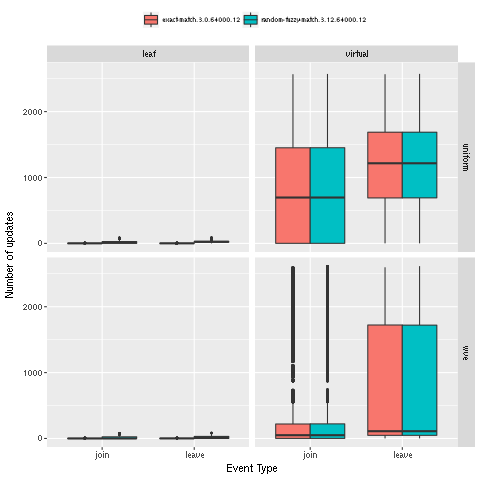

In [11]:
%%R -i switch_event_types_to_update_count
ggplot(switch_event_types_to_update_count) +
   geom_boxplot(aes(y=updates, x=factor(event), 
                    fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap,
                                    numRulesPerLeaf, colocateNumHostsPerLeaf)),
                outlier.size=0.5) +
   facet_grid(groupSizeDist ~ switch) +
   xlab("Event Type") +
   ylab("Number of updates") +
   plotTheme

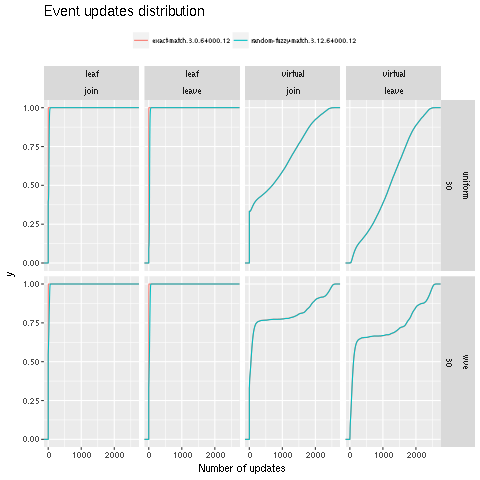

In [12]:
%%R -i switch_event_types_to_update_count
ggplot(switch_event_types_to_update_count) +
   stat_ecdf(aes(x=updates, col=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap, 
                                            numRulesPerLeaf, colocateNumHostsPerLeaf))) +
   facet_grid(groupSizeDist * numBitmaps ~ switch * event) +
   ggtitle("Event updates distribution") +
   xlab("Number of updates") +
   plotTheme

In [13]:
switch_event_types_to_update_count_normalized = DataSetAsDataFrame('switch_event_types_to_update_count_normalized.csv',
                                                                   folders, ['updates', 'switch', 'event'],
                                                                   header=0)

In [14]:
switch_event_types_to_update_count_normalized.head()

,updates,switch,event,groupSizeDist,placementDist,colocateNumHostsPerLeaf,seed,algorithm,numBitmaps,numLeafsPerBitmap,redundancyPerBitmap,numRulesPerLeaf,numEvents
0,0.009259,virtual,join,uniform,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
1,0.500000,virtual,join,uniform,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
2,0.508065,virtual,join,uniform,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
3,0.500000,virtual,join,uniform,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
4,0.455882,virtual,join,uniform,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000


In [22]:
switch_event_types_to_update_count_normalized[
    (switch_event_types_to_update_count_normalized['groupSizeDist'] == 'wve') &
    (switch_event_types_to_update_count_normalized['switch'] == 'virtual') &
    (switch_event_types_to_update_count_normalized['event'] == 'join') &
    (switch_event_types_to_update_count_normalized['updates'] > 1)
]

,updates,switch,event,groupSizeDist,placementDist,colocateNumHostsPerLeaf,seed,algorithm,numBitmaps,numLeafsPerBitmap,redundancyPerBitmap,numRulesPerLeaf,numEvents
13483,1.142857,virtual,join,wve,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
14054,1.142857,virtual,join,wve,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
23207,1.142857,virtual,join,wve,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
23352,1.100000,virtual,join,wve,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
32472,1.125000,virtual,join,wve,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
32605,1.142857,virtual,join,wve,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
32858,1.100000,virtual,join,wve,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
38314,1.142857,virtual,join,wve,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
39726,1.142857,virtual,join,wve,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000
40977,1.142857,virtual,join,wve,colocate-random-random,12,0,exact-match,30,3,0,64000,1000000


In [23]:
switch_event_types_to_update_count_normalized[
    (switch_event_types_to_update_count_normalized['groupSizeDist'] == 'wve') &
    (switch_event_types_to_update_count_normalized['switch'] == 'virtual') &
    (switch_event_types_to_update_count_normalized['event'] == 'join')
]['updates'].describe()

count    951824.000000
mean          0.350246
std           0.244198
min           0.000200
25%           0.010309
50%           0.495868
75%           0.516660
max           1.142857
Name: updates, dtype: float64

In [19]:
switch_event_types_to_update_count_normalized[
    (switch_event_types_to_update_count_normalized['groupSizeDist'] == 'wve') &
    (switch_event_types_to_update_count_normalized['switch'] == 'virtual') &
    (switch_event_types_to_update_count_normalized['event'] == 'leave')
]['updates'].describe()

count    962192.000000
mean          0.513590
std           0.085211
min           0.000200
25%           0.495138
50%           0.508936
75%           0.530702
max           1.166667
Name: updates, dtype: float64

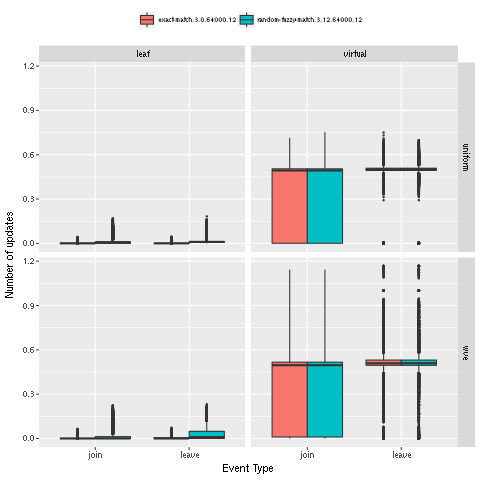

In [15]:
%%R -i switch_event_types_to_update_count_normalized
ggplot(switch_event_types_to_update_count_normalized) +
   geom_boxplot(aes(y=updates, x=factor(event), 
                    fill=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap,
                                    numRulesPerLeaf, colocateNumHostsPerLeaf)),
                outlier.size=0.5) +
   facet_grid(groupSizeDist ~ switch) +
   xlab("Event Type") +
   ylab("Number of updates") +
   plotTheme

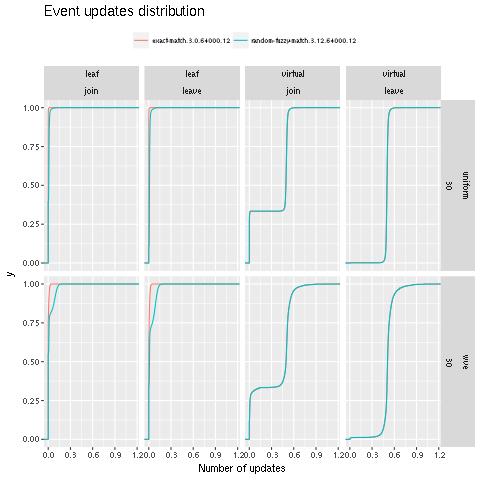

In [16]:
%%R -i switch_event_types_to_update_count_normalized
ggplot(switch_event_types_to_update_count_normalized) +
   stat_ecdf(aes(x=updates, col=interaction(algorithm, numLeafsPerBitmap, redundancyPerBitmap, 
                                            numRulesPerLeaf, colocateNumHostsPerLeaf))) +
   facet_grid(groupSizeDist * numBitmaps ~ switch * event) +
   ggtitle("Event updates distribution") +
   xlab("Number of updates") +
   plotTheme